# Time series visualization

This script is designed to load in the time series generated in gee_landsat_extract or gee_sentinel_extractand plot them out in ways that makes them easy to compare

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# set random seed
np.random.seed(0)

In [47]:
# get the names of all files starting with a certain string in ../../data/EVI
site = "Chokwe"
sensor = "landsat"

names = [f for f in os.listdir(f"../../data/GEE/{sensor}_ts/") if f.startswith(site)]

dataframes = []

for name in names:
    df = pd.read_csv(f"../../data/GEE/{sensor}_ts/{name}")
    df['ID'] = int(name.split(", ")[2].split(".")[0])
    dataframes.append(df)

ts = pd.concat(dataframes)

ts.columns

# filter to remove 2022 since sentinel data is wrong for that year
# ts = ts[ts['year'] <= 2021]


Index(['longitude', 'latitude', 'date', 'EVI', 'NDVI', 'NDWI', 'TIR', 'Cloudy',
       'year', 'month', 'day', 'time', 'site', 'landcover', 'ID'],
      dtype='object')

In [48]:
# Convert 'date' to datetime if it's not already
ts['datetime'] = pd.to_datetime(ts['date'])
ts['date'] = ts['datetime'].dt.date

# Filter for clear observations
ts = ts[ts['Cloudy'] == 0]

# Filter for EVI values not between -1 and 1
# ts = ts[(ts['EVI'] > -1) & (ts['EVI'] < 1)]

In [49]:
# get a list of all the landcovers so that you can plot them
unique_landcovers = ts['landcover'].unique()

# remove water, ocean, and building because these are too easy to spot and they throw off the distribution
unique_landcovers = [x for x in unique_landcovers if x not in ['Water', 'Ocean', 'Building']]

# Create a color palette with the same number of colors as there are unique landcovers
palette = sns.color_palette("husl", len(unique_landcovers))
landcover_color_map = dict(zip(unique_landcovers, palette))

In [50]:
# define the metrics you want to plot
if sensor == 'landsat':
    metrics = ['NDWI', 'NDVI', 'EVI', 'TIR'] # available for landsat
else:
    metrics = ['NDVI'] # EVI also available for sentinel, but the numbers are trash

# If you want to smooth -- Calculate the rolling average of NDVI
if sensor == "sentinel":
    for metric in metrics:
        ts[metric] = ts.groupby('ID')[metric].transform(lambda x: x.rolling(15, min_periods=1).mean())


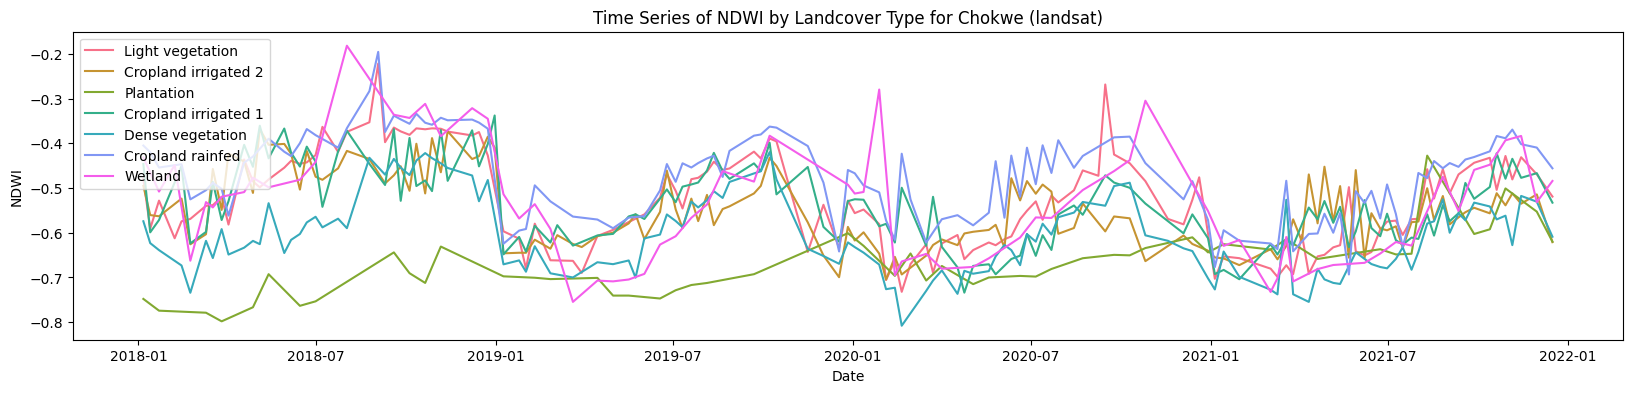

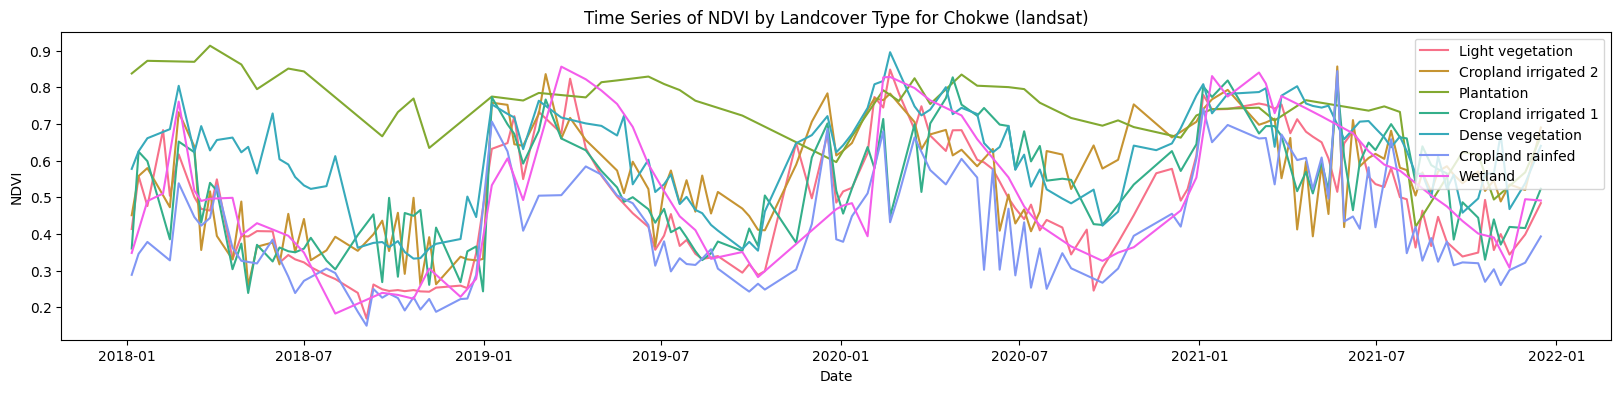

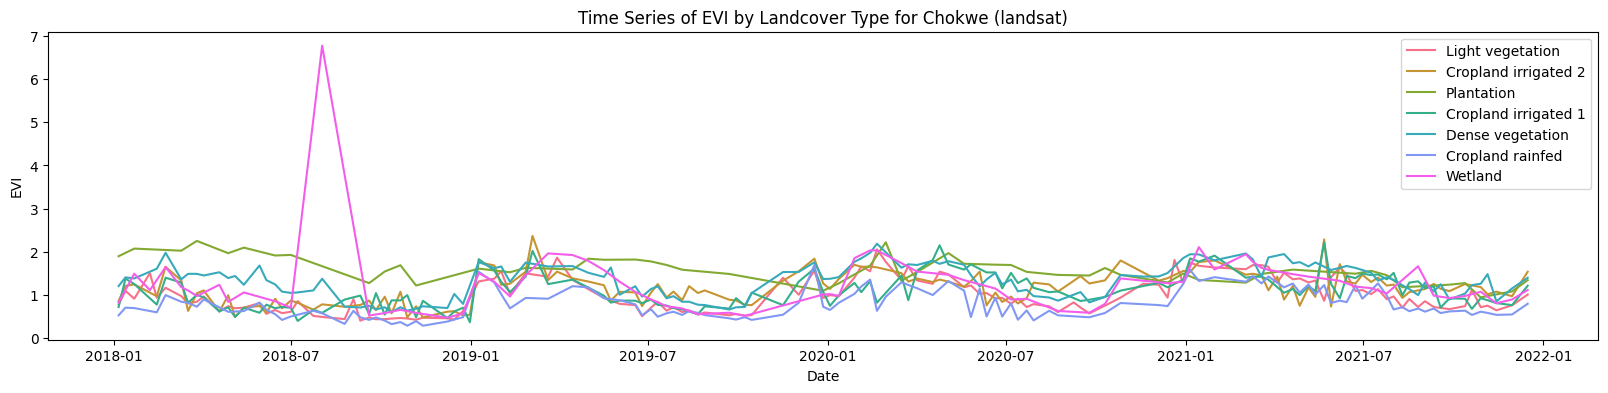

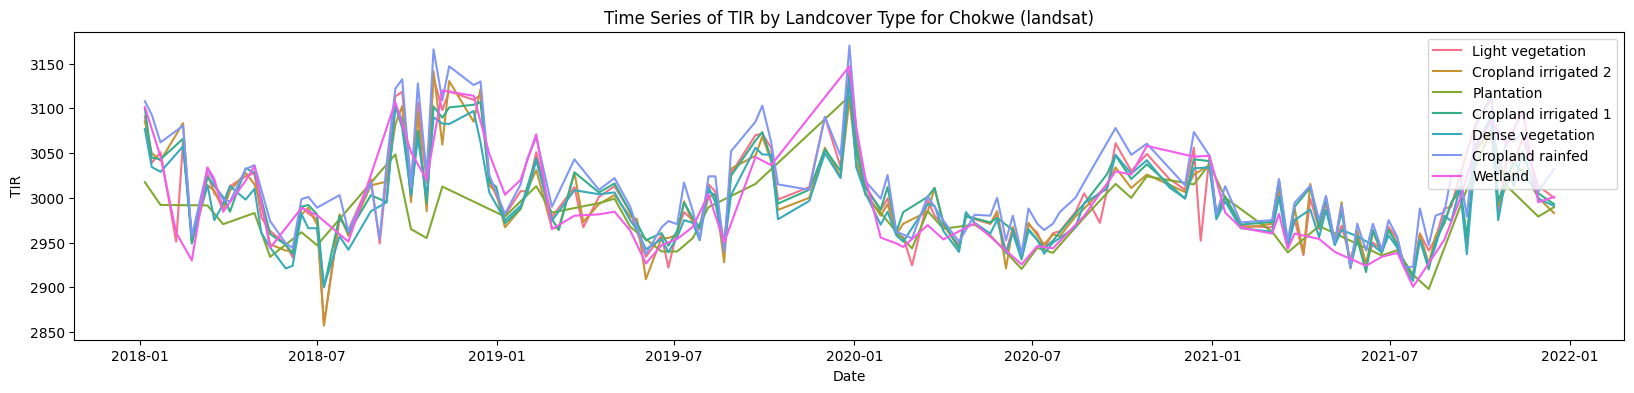

In [51]:
# Plot the median time series for each landcover type
for metric in metrics:
    # Set the plot size
    plt.figure(figsize=(20, 4))

    # Create the line plot with confidence intervals
    for landcover in unique_landcovers:
        sns.lineplot(data=ts[ts['landcover'] == landcover].groupby('date')[metric].median(), label=landcover, color=landcover_color_map[landcover])
    
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.title(f'Time Series of {metric} by Landcover Type for {site} ({sensor})')

    # Show the plot
    plt.show()

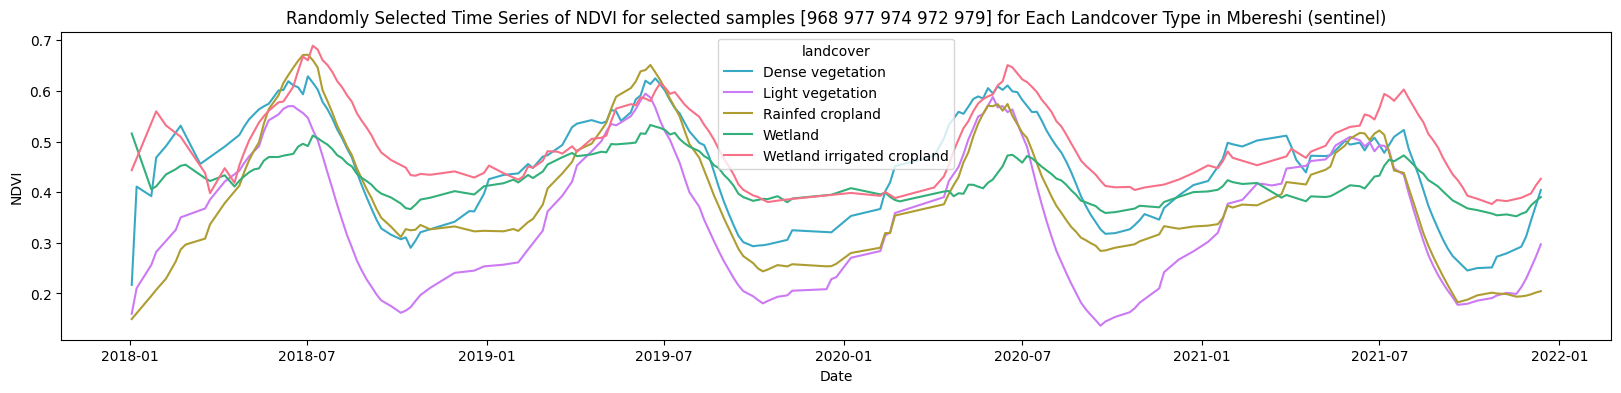

In [14]:
# randomly select one timeseries for each landcover type
selected_examples = pd.DataFrame()

for landcover in unique_landcovers:
    # Randomly select one lat/lon ID from each landcover
    subset = ts[ts['landcover'] == landcover]
    selected_id = np.random.choice(subset['ID'].unique(), 1)[0]
    selected_example = subset[subset['ID'] == selected_id]
    selected_examples = pd.concat([selected_examples, selected_example])

# which IDs were selected?
IDs = selected_examples['ID'].unique()

for metric in metrics:
    plt.figure(figsize=(20, 4))
    sns.lineplot(data=selected_examples.groupby(['date', 'landcover'])[metric].mean().reset_index(), 
                x='date', y=metric, hue='landcover', palette=landcover_color_map)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.title(f'Randomly Selected Time Series of {metric} for selected samples {IDs} for Each Landcover Type in {site} ({sensor})')

    # Show the plot
    plt.show()


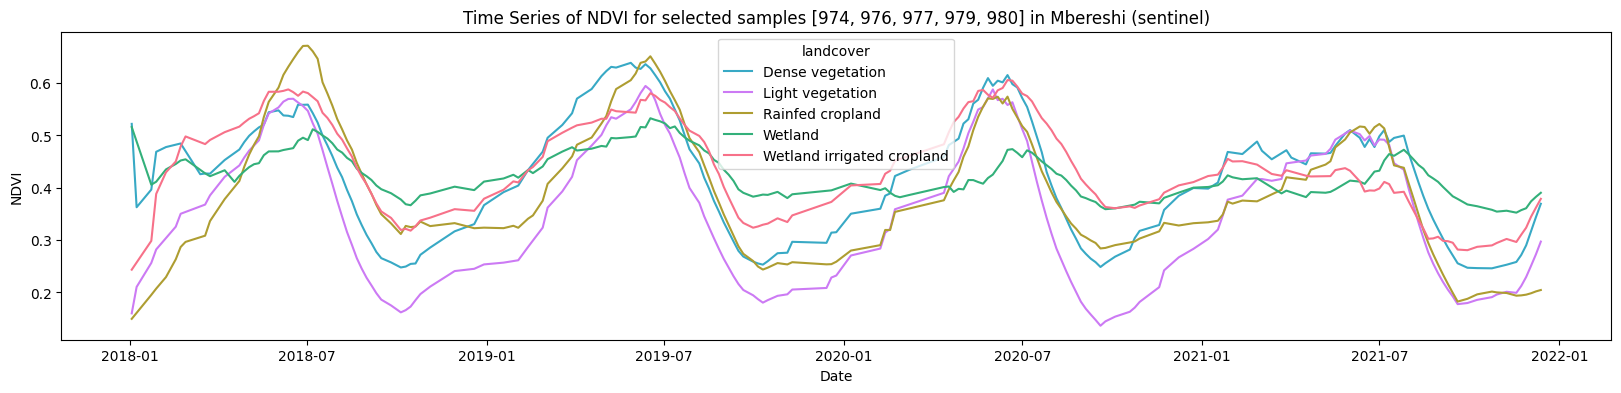

In [15]:
# Choose specific indices to plot
if site == "Catandica":
    IDs = [312, 39, 534, 383]
if site == "Chokwe":
    IDs = [280, 85, 598, 451]
if site == "Manica":
    IDs = [412, 583, 277, 14]
if site == "Xai-Xai":
    IDs = [812, 804, 813, 808, 781, 809]
if site == "Mbereshi":
    IDs = [974, 976, 977, 979, 980]
else:
    IDs = []

selected_examples = ts[ts['ID'].isin(IDs)]

for metric in metrics:
    plt.figure(figsize=(20, 4))
    sns.lineplot(data=selected_examples.groupby(['date', 'landcover'])[metric].mean().reset_index(), 
                x='date', y=metric, hue='landcover', palette=landcover_color_map)

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.title(f'Time Series of {metric} for selected samples {IDs} in {site} ({sensor})')

    # Show the plot
    plt.show()

In [9]:
# save the csv so that I can get ChatGPT to look at it
# ts.to_csv(f"../../data/test.csv", index=False)